# DTSA-5511 Final Project: Can Machines Understand Emotion?

**Genesis Zhong**

https://github.com/genesischung/5511_sentiment_analysis

## Introduction

In DTSA-5510, I was first exposed to the concept of Natural Language Processing (NLP), which, in essence, is empowering computers to be able to interpret human language. I was very intrigued by NLP, so my final project for 5510 was also a NLP project that interprets the text from e-commerce descriptions.

In this course, we did a NLP project in Week 4, and I very much enjoyed it. I know that neural networks are quite advanced and with enough training, machines can interpret human language just fine. But I couldn't help but wonder if deep learning models can understand human emotion, which will be more difficult to understand than just the language itself. Anyhow, I decided to explore this idea as my final project for this class.

As I googled online, I realized that this idea has been around for a while. The process of using computers to interpret human emotion from texts is called sentiment analysis. 

## Data Set Description

For this project, I will be using the `Large Movie Review Dataset` from the 2011 paper `Learning Word Vectors for Sentiment Analysis` by Andrew Maas et al. (https://ai.stanford.edu/~amaas/data/sentiment/) This data set contains 50000 reviews from IMDb, the Internet Movie Database. Each entry contains the review text, and a label of 0 or 1, indicating the sentiment of this review.

The original data set uses 50% of the data as the training set, and the rest 50% as the test set. I personally would like a bigger training set, with a small testing set and a validation set. So I will use a repackaged version of the data set hosted on Kaggle (https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format).

The repackaged data set contains 3 files:
- Train.csv:  40000 rows (80%) of data, 2 columns: `text` for movie review text, `label` for sentiment label
- Test.csv: 5000 rows (10%) of data, 2 columns: `text` for movie review text, `label` for sentiment label
- Valid.csv: 5000 rows of (10%) data, 2 columns: `text` for movie review text, `label` for sentiment label

## Setup

In [1]:
!conda activate tf
!nvidia-smi

usage: conda [-h] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'activate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'env')
Tue Aug 15 22:10:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98.01              Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 

In [2]:
import os
# suppress tensorflow INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# proxy needed to download from nltk
nltk.set_proxy('http://172.18.32.1:2334')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization 
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/myzhong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/myzhong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/myzhong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-08-15 22:10:15.519909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df_train = pd.read_csv("data/Train.csv")
df_test = pd.read_csv("data/Test.csv")
df_valid = pd.read_csv("data/Valid.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [6]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [7]:
df_train.sample(5)

,text,label
34814,Such a shame that this wonderful bright spot o...,1
13886,I was really looking forward to seeing this fi...,0
28342,Closer to reality and containing more depth th...,0
5707,"This is a comedy of morals, so occasionally a ...",1
34847,"MY LEFT FOOT, in my opinion, is a great biopic...",1


## EDA

In [8]:
# show 5 examples of positive reviews
with pd.option_context('display.max_colwidth', None):
    display(df_train[df_train.label==1].head(5))

,text,label
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn't cash the cheque (something that is rarely done now).<br /><br />It follows through the early years of getting equipment and uniforms, starting up and training. All in all, its a great film for a boring Sunday afternoon. <br /><br />Two draw backs. One is the Germans bogus dodgy accents (come one, Germans cant pronounced the letter ""W"" like us) and Two The casting of Liz Frazer instead of the familiar Janet Davis. I like Liz in other films like the carry ons but she doesn't carry it correctly in this and Janet Davis would have been the better choice.",1
6,"Finally watched this shocking movie last night, and what a disturbing mindf**ker it is, and unbelievably bloody and some unforgettable scenes, and a total assault on the senses. Looks like a movie from the minds of Lynch (specifically ERASERHEAD), Buttgereit, and even a little of ""Begotten"". What this guy does to his pregnant sister is beyond belief, but then again, did it really happen or is it his brain's left and right sides doing battle. That's the main theme of this piece of art, to draw a fine line between fantasy and reality, and what would happen if the right side of the brain that dreams and fantasizes overtakes the reasoning and logical left side. And the music in this movie is unbelievable, a kind of electronic score that is absolutely perfect. Even though this movie is totally shocking and pretty disgusting in some of the most extreme scenes (including hard core sex) you will ever see in any movie, I viewed it as a work of art, and loved it. And that music still amazes me, I have to try and find the soundtrack if is available. Watching ""Subconscious Cruelty"" is a real event, and not something the viewer will easily forget. And a note to gorehounds, this is a must-have.<br /><br />Warning... Be careful buying this movie, because some prints have fogging on the graphic sex scenes and extreme gore, especially the copies from the Japanese release.",1
8,"It may be the remake of 1987 Autumn's Tale after eleven years, as the director Mabel Cheung claimed. Mabel employs rock music as the medium in this movie to express her personal attitude to life, in which love, desire and the consequential frustration play significantly crucial roles. Rock music may not be the best vehicle to convey the profound sentiment, and yet it is not too inappropriate to utilize it as the life of underground rock musicians is bitterly more intense than an ordinary one. The director focuses on the depiction of subtle affection and ultimate vanity of life rather than mere rock music. The love between father and son, lovers, and friends is delicately and touchingly delivered through the fine performance. Mabel does not attempt to beautify rock musicians as artists at all, instead, she tries to reproduce a true life on screen, making huge efforts of years' working on this project and gathering information in Beijing underground pubs.<br /><br />Daniel has given probably the best performance in all his movies made so far. His innate dispiritedness and reticence fit the blue mood of the film perfectly.",1
9,"My Super Ex Girlfriend turned out to be a pleasant surprise for me, I was really expecting a horrible movie that would probably be stupid and predictable, and you know what? It was! But this movie did have so many wonderful laughs and a fun plot that anyone could get a kick out of. I know that this was a very cheesy movie, but Uma and Anna were just so cool and Steve was such a great addition along with a great cast that looked like they had so much fun and

In [9]:
# show 5 examples of negative reviews
with pd.option_context('display.max_colwidth', None):
    display(df_train[df_train.label==0].head(5))

,text,label
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.",0
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, but the animation in particular is a sad sight. The storyline is also pretty weak, as its more like three episodes of Schooby-Doo than the single adventurous story we got the last time. But dont misunderstand, it's not very good Schooby-Doo episodes. I didnt laugh a single time, although I might have sniggered once or twice.<br /><br />To the audience who haven't seen the first movie, or don't especially care for a similar sequel, here is a fast review of this movie as a stand-alone product: If you liked schooby-doo, you might like this movie. If you didn't, you could still enjoy this movie if you have nothing else to do. And I suspect it might be a good kids movie, but I wouldn't know. It might have been better if Milo's Return had been a three-episode series on a cartoon channel, or on breakfast TV.",0
2,"Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? ""I'll show those old meanies, I'll put out my own movie and prove that you don't have to know nuttin about your topic to still make money!"" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I'm running the other way. It's child abuse to let parents that worthless raise kids. It's audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.",0
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if

After seeing some review contents, we should remove URLs and HTML tags in addition to the routine data cleasing.

So in the function below, we remove URL and HTML tags, along with stop words and punctuation from the texts. We also perform lemmatization in the process.

In [10]:
# Data Cleansing    
def data_cleasning(text):
    # remove URL
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    
    # remove HTML tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'',text)

    # remove stop_words and punctuation
    stop = stopwords.words('english')       
    stpwrd = stop + list(punctuation)
    
    # lemmatization
    lemma = WordNetLemmatizer()
    word_tokens = [t for t in word_tokenize(text) if t.isalpha()]
    cleaned_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stpwrd]
    
    return " ".join(cleaned_token)


In [11]:
df_train['text'] = df_train['text'].apply(lambda x:data_cleasning(x))
df_test['text'] = df_test['text'].apply(lambda x:data_cleasning(x))
df_valid['text'] = df_valid['text'].apply(lambda x:data_cleasning(x))

First we plot the number of reviews in each label. If we have an unbalanced distribution of the labels, we may not be able to reliably train the model. In the plot below, we can see that we have roughly the same number of reviews for each label.

[Text(0.5, 1.0, 'Number of Reviews in Each Label (Training Set)')]

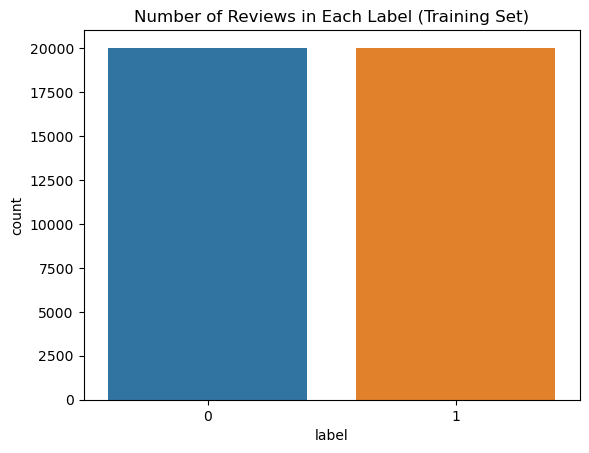

In [80]:
sns.countplot(x='label', data=df_train).set(title="Number of Reviews in Each Label (Training Set)")

If the reviews are too short, they may not have sufficient information for the models to process. So below we plotted the length of reviews in number of words. As we can see in the distribution plot, the most majority of reviews are over 50 words in length, with the medium being around 100 words in length. This should give us enough information to work with.

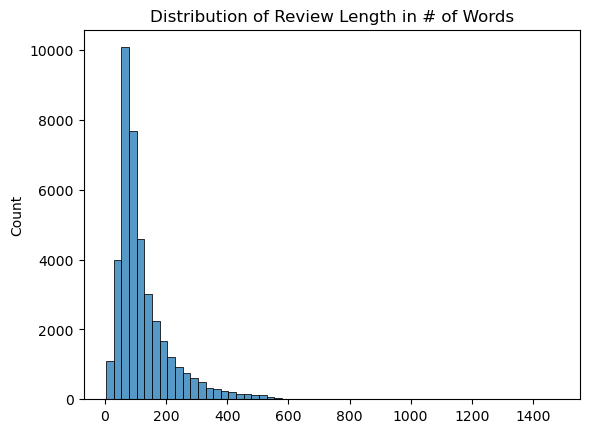

In [13]:
def plot_length(df):
    """
    plot the length of review in # of words in the training set
    """
    lengths = [len(text.split()) for text in df['text']]
    sns.histplot(x=lengths, binwidth=25).set(title="Distribution of Review Length in # of Words")

plot_length(df_train)

Next, we build word clouds for the positive reviews and negative reviews to hopefully be able to spot some difference between the two labels.

At the first glance, the two word clouds look rather similar, with neutral words like `film`, `movie`, and `character` taking up a lot of the space. 

In [14]:
def plot_wordcloud(df, positive=True):
    plt.figure(figsize = (12,12)) 
    
    if positive:
        wc = WordCloud(max_words = 100, 
                    width = 720, 
                    height = 1080).generate(" ".join(df[df['label'] == 1]['text']))
    else:
        wc = WordCloud(max_words = 100, 
                    width = 720, 
                    height = 1080).generate(" ".join(df[df['label'] == 0]['text']))
        
    plt.axis('off')                                                
    plt.imshow(wc , interpolation = 'bilinear')


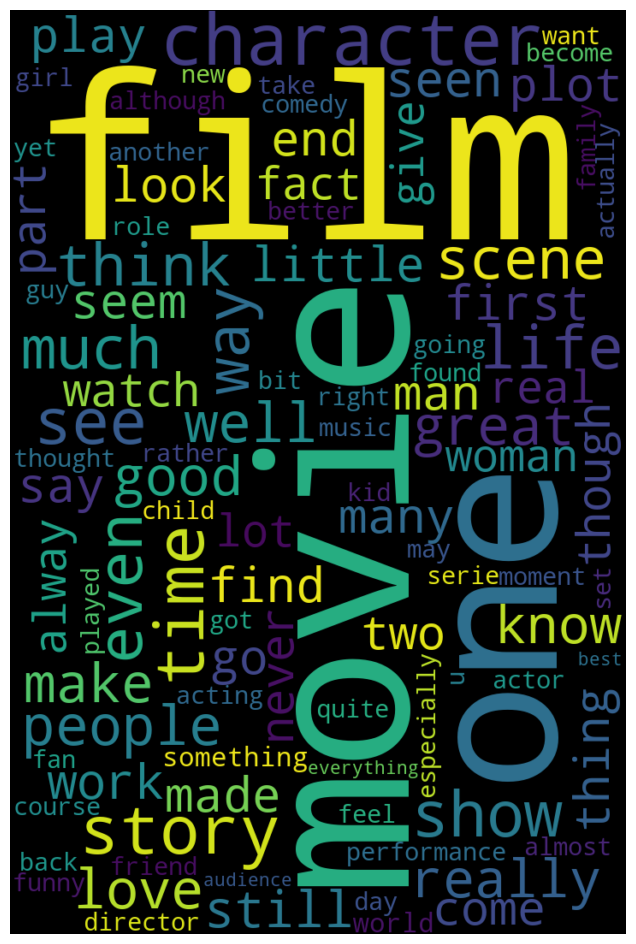

In [15]:
plot_wordcloud(df_train, True)

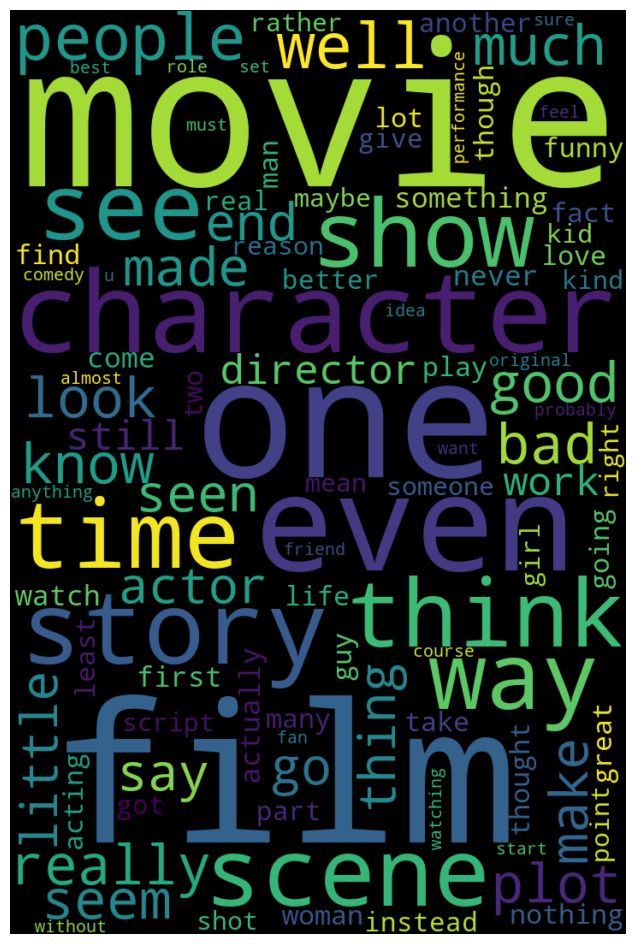

In [16]:
plot_wordcloud(df_train, False)

As the less frequent terms we want to examine are smaller on the word clouds, below we plot the top 50 most frequent terms in both positive reviews and negative reviews.

The two plots below concur with the word clouds that a lot of neutral terms are frequent across both labels. But we can also spot some terms unique to one category. For example, `best` is in the top 50 words in positive reviews, but not in negative reviews. One may notice that `better` and `good` appear in both plots, despite these clearly being positive terms. Anyhow, the complexity of this project is rather high.

In [17]:
def plot_top_words(df, n=20, positive=True):    
    vec = CountVectorizer(stop_words='english',
                         lowercase=True,
                         max_features=n)
    if positive:
        X = vec.fit_transform(df[df['label']==1]['text'])
        title="Top {} Most Frequent Words in Positive Reviews".format(n)
    else:
        X = vec.fit_transform(df[df['label']==0]['text'])
        title="Top {} Most Frequent Words in Negative Reviews".format(n)      
        
    plt.figure(figsize=(6, n/5))
    sns.barplot(x=np.sum(X.toarray(), axis=0),
                y=vec.get_feature_names_out(),
                orient='h').set(title=title)

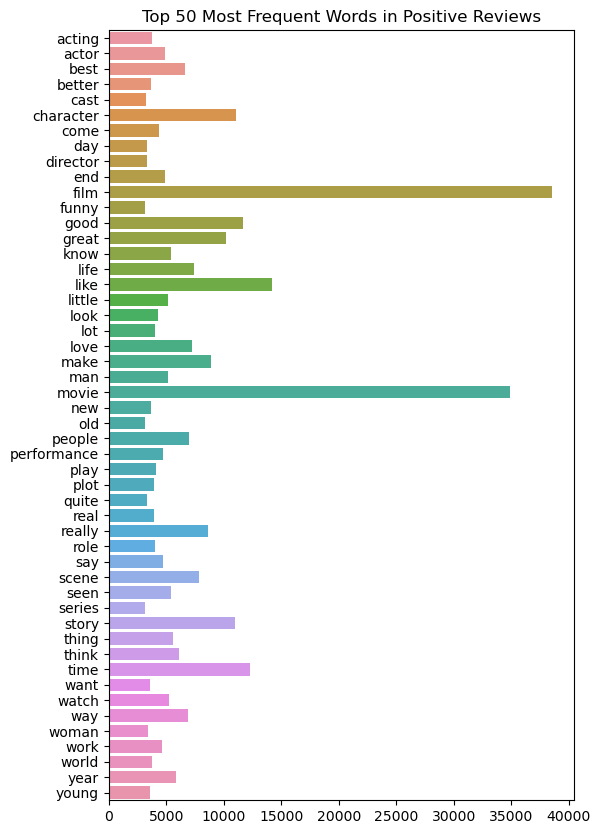

In [18]:
plot_top_words(df_train, 50, True)

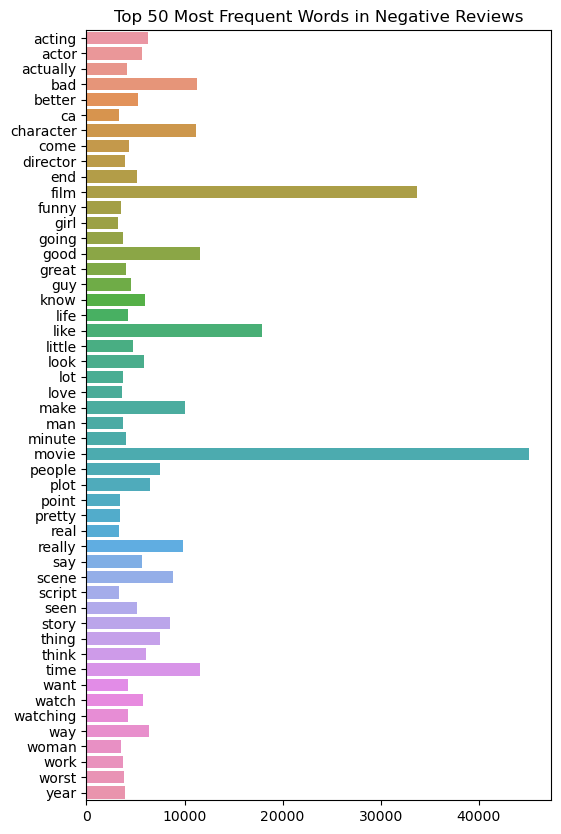

In [19]:
plot_top_words(df_train, 50, False)

## Modeling

### Prepare Data Set

Keras models work the best with tf.data.Dataset format, so we setup the train, validation, and test dataset.

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(df_train['text']), np.array(df_train['label'])))
valid_dataset = tf.data.Dataset.from_tensor_slices((np.array(df_valid['text']), np.array(df_valid['label'])))
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(df_test['text']), np.array(df_test['label'])))

### Vectorize Layer Setup

We will be using the `TextVectorization` layer from tensorflow, as the Tokenizer method is now deprecated.

Before using the vectorize layer, we need to first call `adapt()` to build the vocabulary for tokenizaion. 

In [21]:
max_features = 5000
sequence_length = 48
learning_rate = 3e-5

text_dataset = tf.data.Dataset.from_tensor_slices(np.array(df_train['text']))

vectorize_layer = TextVectorization(
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length
)

vectorize_layer.adapt(text_dataset.batch(256))

### Model 1: LSTM

The first model is LSTM based, which is what we primarily used in the week 4 NLP project. The architecture of the model is outlined in the plot below.

The input from the text vectorizer is fed through an embedding layer, then a bi-directional LSTM layer. Finally, we use a fully-connected layer to output the signal. Dropout is applied both between the embedding layer and Bi-LSTM, and between Bi-LSTM and FC layer.

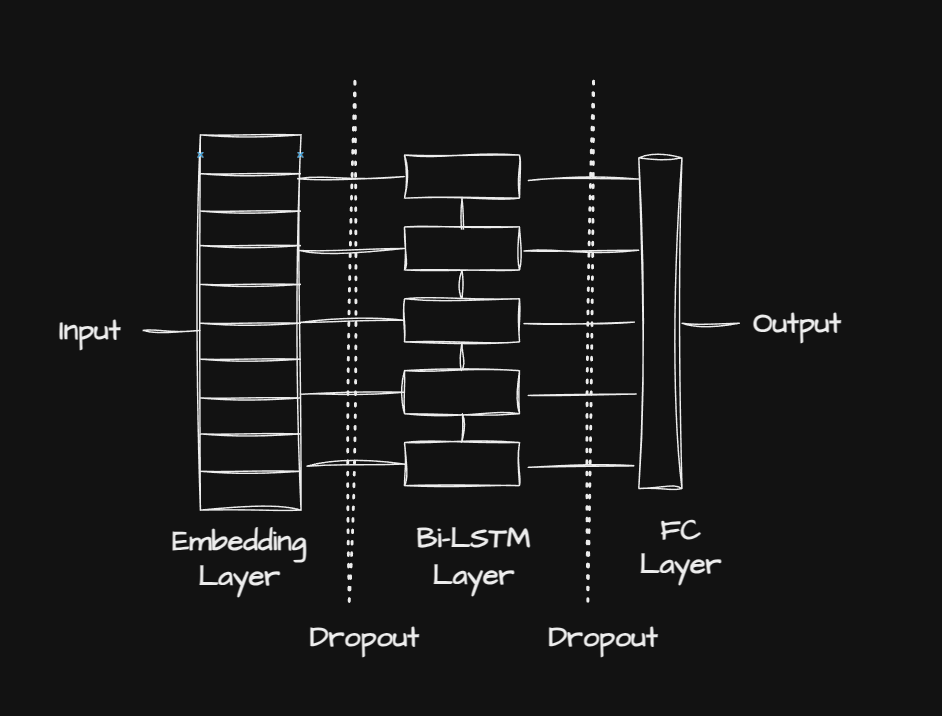

In [22]:
lstm = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

lstm.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

In [23]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 48, 128)           640128    
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [24]:
lstm_hist = lstm.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)

         

Epoch 1/50
157/157 - 16s - loss: 0.6921 - accuracy: 0.5298 - val_loss: 0.6910 - val_accuracy: 0.5610 - 16s/epoch - 100ms/step
Epoch 2/50
157/157 - 4s - loss: 0.6882 - accuracy: 0.5714 - val_loss: 0.6734 - val_accuracy: 0.6082 - 4s/epoch - 25ms/step
Epoch 3/50
157/157 - 5s - loss: 0.5552 - accuracy: 0.7125 - val_loss: 0.4820 - val_accuracy: 0.7670 - 5s/epoch - 29ms/step
Epoch 4/50
157/157 - 5s - loss: 0.4717 - accuracy: 0.7760 - val_loss: 0.4552 - val_accuracy: 0.7856 - 5s/epoch - 29ms/step
Epoch 5/50
157/157 - 5s - loss: 0.4438 - accuracy: 0.7912 - val_loss: 0.4412 - val_accuracy: 0.7914 - 5s/epoch - 29ms/step
Epoch 6/50
157/157 - 5s - loss: 0.4214 - accuracy: 0.8047 - val_loss: 0.4350 - val_accuracy: 0.7944 - 5s/epoch - 29ms/step
Epoch 7/50
157/157 - 5s - loss: 0.4082 - accuracy: 0.8123 - val_loss: 0.4278 - val_accuracy: 0.8012 - 5s/epoch - 29ms/step
Epoch 8/50
157/157 - 5s - loss: 0.3992 - accuracy: 0.8183 - val_loss: 0.4238 - val_accuracy: 0.8032 - 5s/epoch - 29ms/step
Epoch 9/50
15

In [25]:
def plot_graphs(history, metric, title):
    """
    Plot selected metric from model training history
    """
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(title)

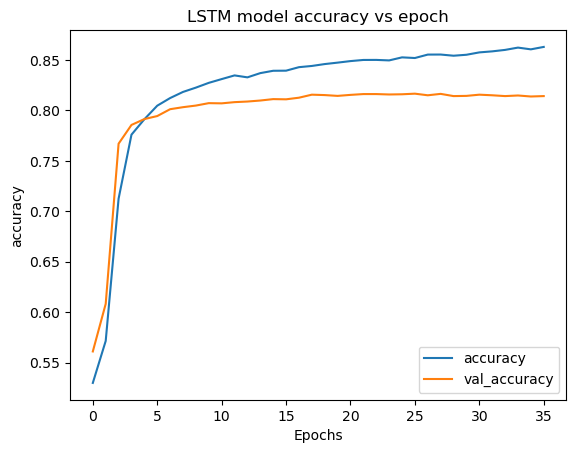

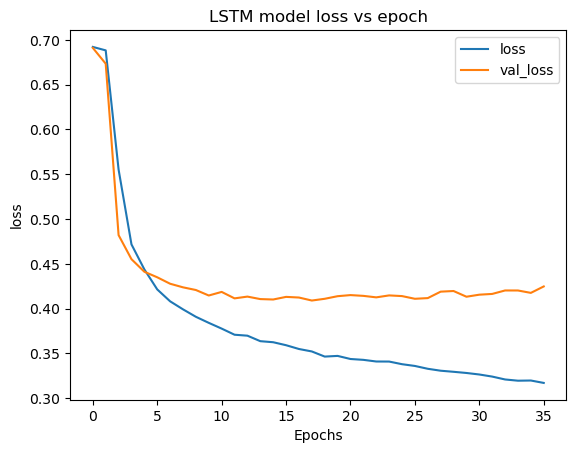

In [26]:
plot_graphs(lstm_hist, 'accuracy', "LSTM model accuracy vs epoch")
plot_graphs(lstm_hist, 'loss', "LSTM model loss vs epoch")

### Model 2: CNN

The second model is a CNN, which is also what we have covered in this course. In the cancer detection project, we used CNNs to process images. But CNN can be used on text as well. The designed architecture is shown in the plot below.

After receiving word embeddings from the embedding layer, the 1 dimentional convolutional layer's output will be pooled to a smaller dimension, which is then fed into two fully-connected layers. Dropout will be applied between the two FC layers.


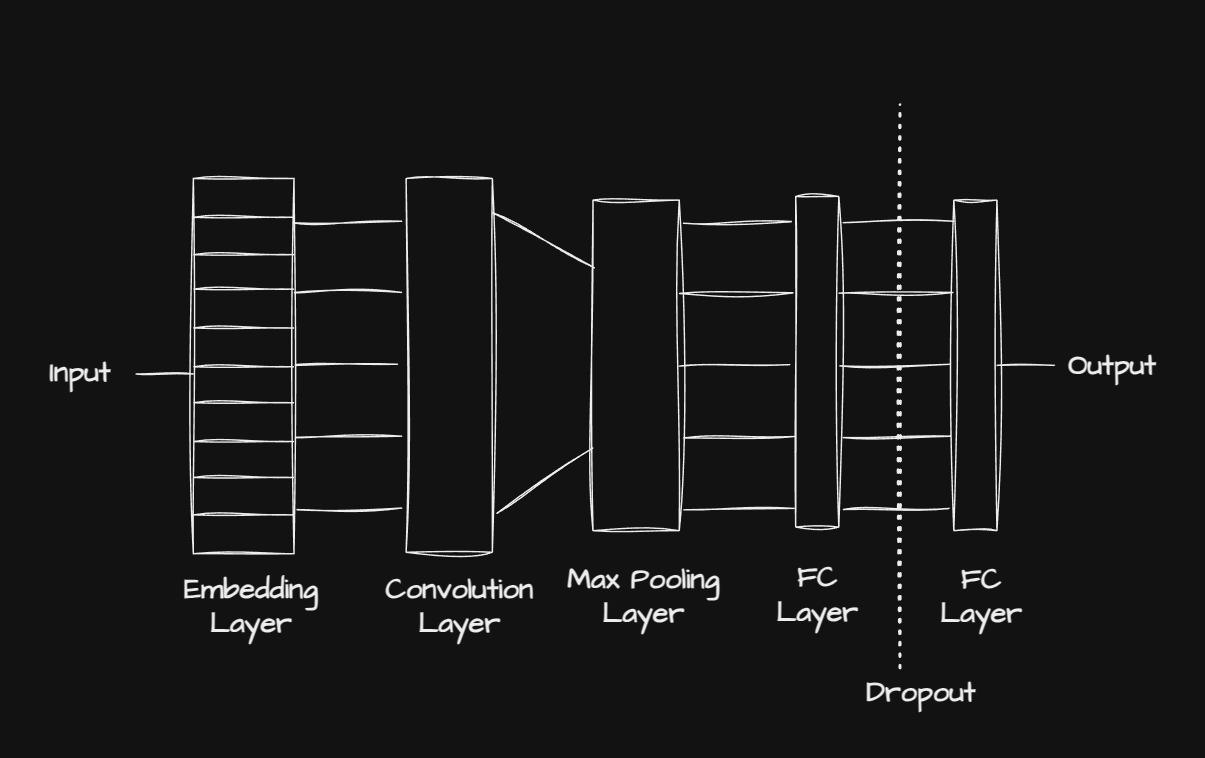

In [27]:
cnn = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Conv1D(256, 3, padding='valid', strides=1, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

cnn.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 48, 128)           640128    
                                                                 
 conv1d (Conv1D)             (None, 46, 256)           98560     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [28]:
cnn_hist = cnn.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)

         

Epoch 1/50
157/157 - 10s - loss: 0.6927 - accuracy: 0.5118 - val_loss: 0.6907 - val_accuracy: 0.5838 - 10s/epoch - 65ms/step
Epoch 2/50
157/157 - 1s - loss: 0.6891 - accuracy: 0.5467 - val_loss: 0.6871 - val_accuracy: 0.6352 - 1s/epoch - 9ms/step
Epoch 3/50
157/157 - 1s - loss: 0.6835 - accuracy: 0.5956 - val_loss: 0.6805 - val_accuracy: 0.6626 - 1s/epoch - 9ms/step
Epoch 4/50
157/157 - 1s - loss: 0.6722 - accuracy: 0.6536 - val_loss: 0.6662 - val_accuracy: 0.6818 - 1s/epoch - 9ms/step
Epoch 5/50
157/157 - 1s - loss: 0.6509 - accuracy: 0.6973 - val_loss: 0.6404 - val_accuracy: 0.6966 - 1s/epoch - 9ms/step
Epoch 6/50
157/157 - 1s - loss: 0.6172 - accuracy: 0.7293 - val_loss: 0.6060 - val_accuracy: 0.7160 - 1s/epoch - 9ms/step
Epoch 7/50
157/157 - 1s - loss: 0.5763 - accuracy: 0.7486 - val_loss: 0.5682 - val_accuracy: 0.7278 - 1s/epoch - 9ms/step
Epoch 8/50
157/157 - 1s - loss: 0.5339 - accuracy: 0.7624 - val_loss: 0.5324 - val_accuracy: 0.7408 - 1s/epoch - 9ms/step
Epoch 9/50
157/157 - 

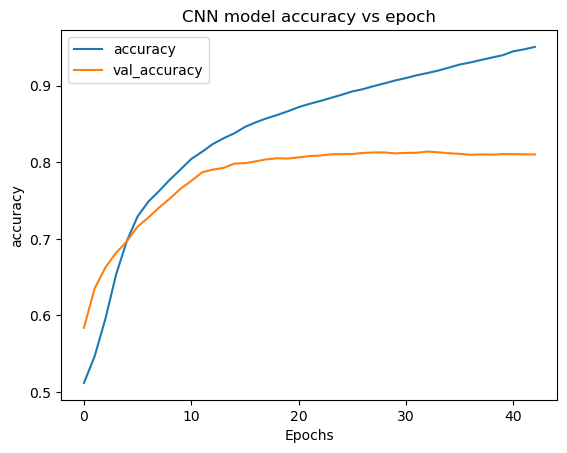

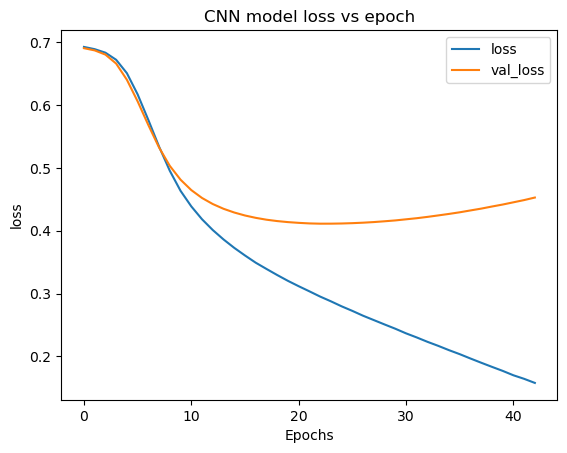

In [29]:
plot_graphs(cnn_hist, 'accuracy', "CNN model accuracy vs epoch")
plot_graphs(cnn_hist, 'loss', "CNN model loss vs epoch")

### Model 3: CNN_LSTM

Next, I want to combine CNN and LSTM to form a complex neural network. Pedro Sosa proposed a CNN_LSTM model and a LSTM_CNN model in his 2017 paper `Twitter Sentiment Analysis using combined LSTM-CNN Models`. So I decided to implement these two models to see how they work in this project.

First I implemented the CNN_LSTM model shown in the plot below. We started building the model like a CNN. After pooling the output from the convolutional layer, we feed the output to a Bi-LSTM layer as opposed to a FC layer.

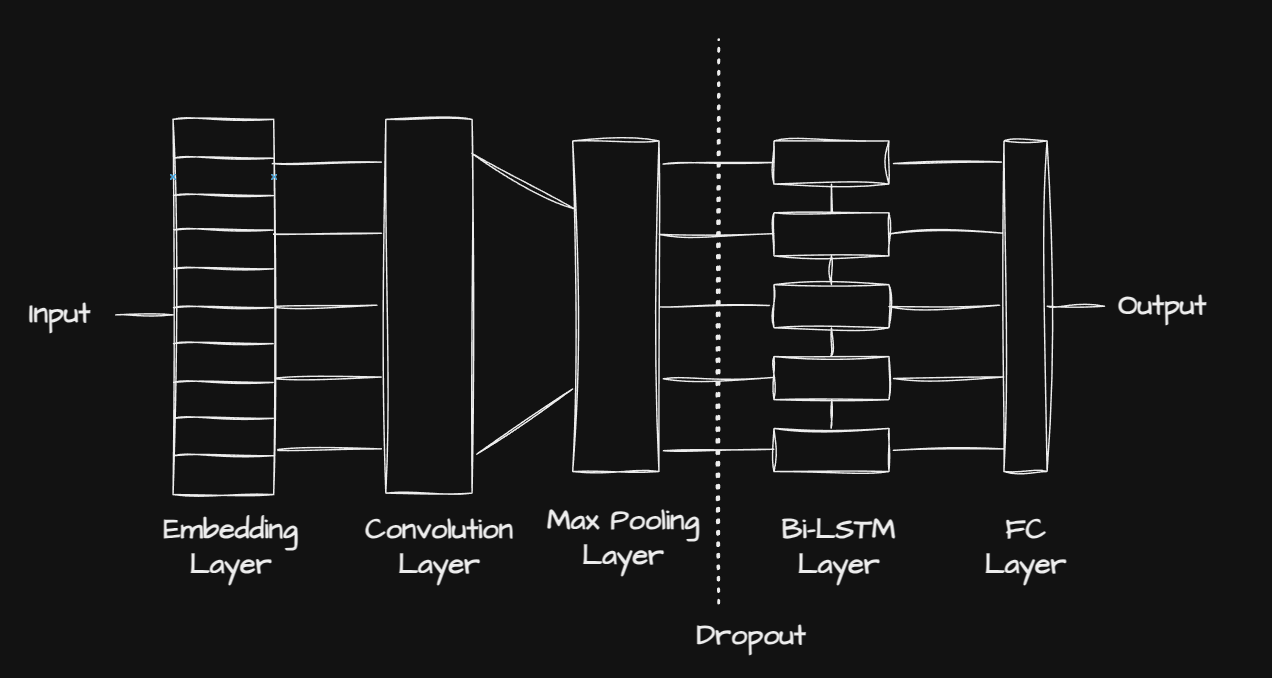

In [30]:
cnn_lstm = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Conv1D(256, 3, padding='valid', strides=1, activation='relu'),
        GlobalMaxPooling1D(keepdims=True),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dense(1, activation='sigmoid')
    ]
)

cnn_lstm.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

cnn_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 48, 128)           640128    
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 256)           98560     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 1, 256)            0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)              

In [31]:
cnn_lstm_hist = cnn_lstm.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)         

Epoch 1/50
157/157 - 11s - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy: 0.5726 - 11s/epoch - 72ms/step
Epoch 2/50
157/157 - 2s - loss: 0.6924 - accuracy: 0.5329 - val_loss: 0.6921 - val_accuracy: 0.6244 - 2s/epoch - 12ms/step
Epoch 3/50
157/157 - 2s - loss: 0.6914 - accuracy: 0.5585 - val_loss: 0.6907 - val_accuracy: 0.6338 - 2s/epoch - 12ms/step
Epoch 4/50
157/157 - 2s - loss: 0.6887 - accuracy: 0.5937 - val_loss: 0.6866 - val_accuracy: 0.6460 - 2s/epoch - 12ms/step
Epoch 5/50
157/157 - 2s - loss: 0.6800 - accuracy: 0.6360 - val_loss: 0.6715 - val_accuracy: 0.6742 - 2s/epoch - 12ms/step
Epoch 6/50
157/157 - 2s - loss: 0.6503 - accuracy: 0.6873 - val_loss: 0.6269 - val_accuracy: 0.7034 - 2s/epoch - 12ms/step
Epoch 7/50
157/157 - 2s - loss: 0.5926 - accuracy: 0.7245 - val_loss: 0.5640 - val_accuracy: 0.7322 - 2s/epoch - 12ms/step
Epoch 8/50
157/157 - 2s - loss: 0.5295 - accuracy: 0.7560 - val_loss: 0.5133 - val_accuracy: 0.7524 - 2s/epoch - 12ms/step
Epoch 9/50
157

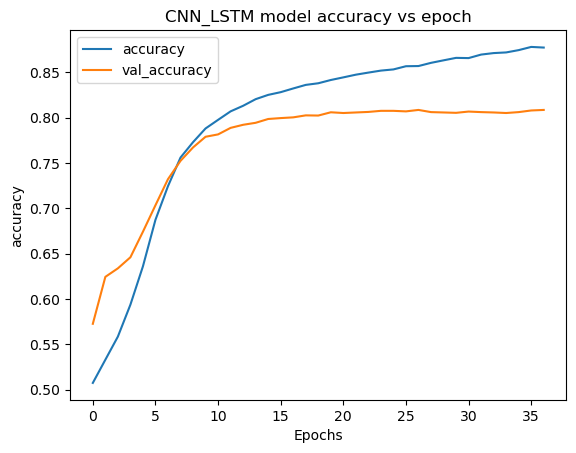

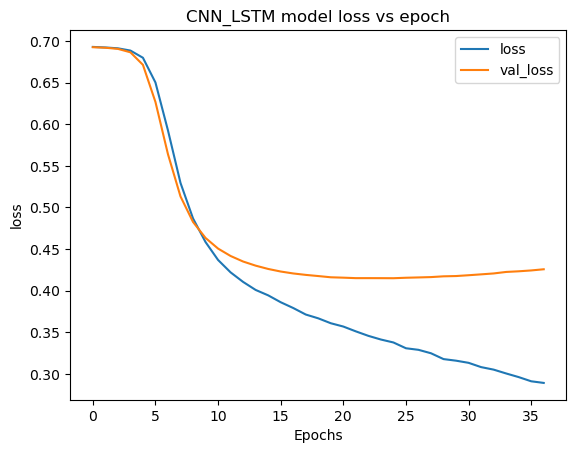

In [32]:
plot_graphs(cnn_lstm_hist, 'accuracy', "CNN_LSTM model accuracy vs epoch")
plot_graphs(cnn_lstm_hist, 'loss', "CNN_LSTM model loss vs epoch")

### Model 4: LSTM_CNN

After implementing the CNN_LSTM model, we then proceed to implement the LSTM_CNN model, which is shown in the plot below.

In this model, the output of the Bi-LSTM layer is fed through a 1D convolutional layer. The output of the convolutional layer will be pooled through a max pooling layer, which is then fed through a FC layer to output the signal.

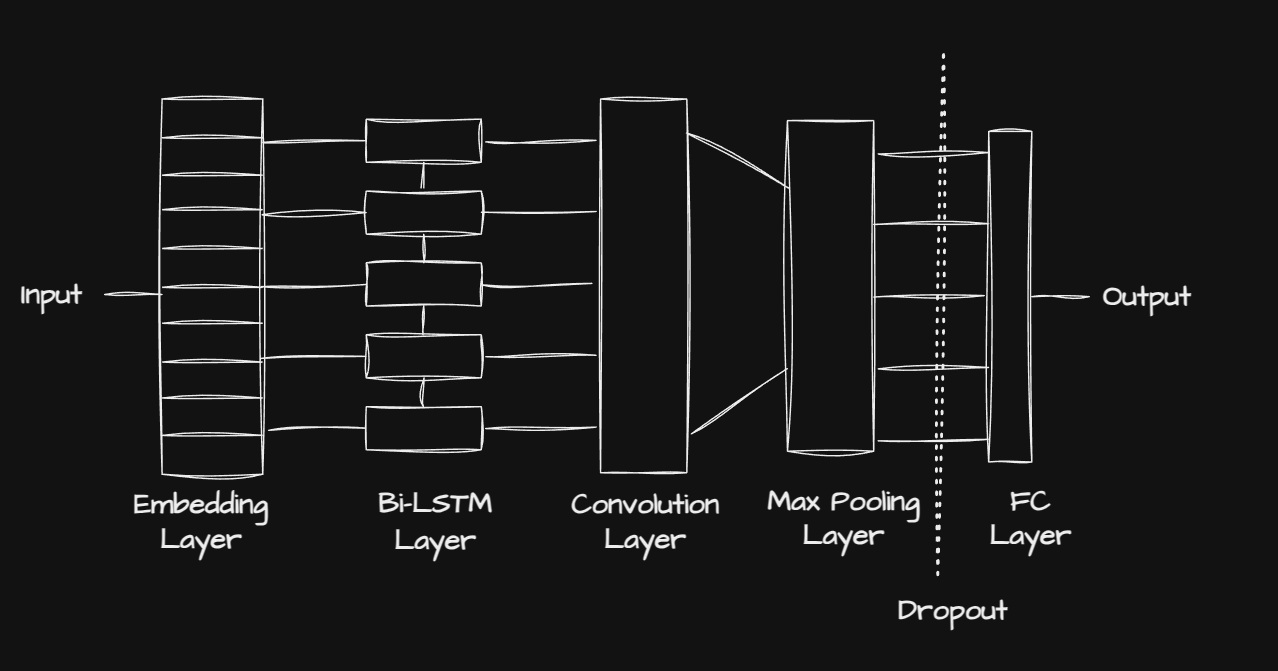

In [33]:
lstm_cnn = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Bidirectional(LSTM(128, return_sequences=True)),
        Conv1D(256, 3, padding='valid', strides=1, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

lstm_cnn.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

lstm_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 48, 128)           640128    
                                                                 
 bidirectional_2 (Bidirecti  (None, 48, 256)           263168    
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 256)           196864    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                      

In [34]:
lstm_cnn_hist = lstm_cnn.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)


Epoch 1/50
157/157 - 12s - loss: 0.6918 - accuracy: 0.5287 - val_loss: 0.6887 - val_accuracy: 0.6068 - 12s/epoch - 78ms/step
Epoch 2/50
157/157 - 6s - loss: 0.6105 - accuracy: 0.6781 - val_loss: 0.5168 - val_accuracy: 0.7456 - 6s/epoch - 36ms/step
Epoch 3/50
157/157 - 6s - loss: 0.4321 - accuracy: 0.8008 - val_loss: 0.4561 - val_accuracy: 0.7856 - 6s/epoch - 37ms/step
Epoch 4/50
157/157 - 6s - loss: 0.3863 - accuracy: 0.8294 - val_loss: 0.4421 - val_accuracy: 0.7962 - 6s/epoch - 37ms/step
Epoch 5/50
157/157 - 6s - loss: 0.3643 - accuracy: 0.8424 - val_loss: 0.4355 - val_accuracy: 0.8024 - 6s/epoch - 37ms/step
Epoch 6/50
157/157 - 6s - loss: 0.3491 - accuracy: 0.8515 - val_loss: 0.4331 - val_accuracy: 0.8052 - 6s/epoch - 37ms/step
Epoch 7/50
157/157 - 6s - loss: 0.3376 - accuracy: 0.8577 - val_loss: 0.4339 - val_accuracy: 0.8100 - 6s/epoch - 37ms/step
Epoch 8/50
157/157 - 6s - loss: 0.3291 - accuracy: 0.8623 - val_loss: 0.4361 - val_accuracy: 0.8138 - 6s/epoch - 37ms/step
Epoch 9/50
157

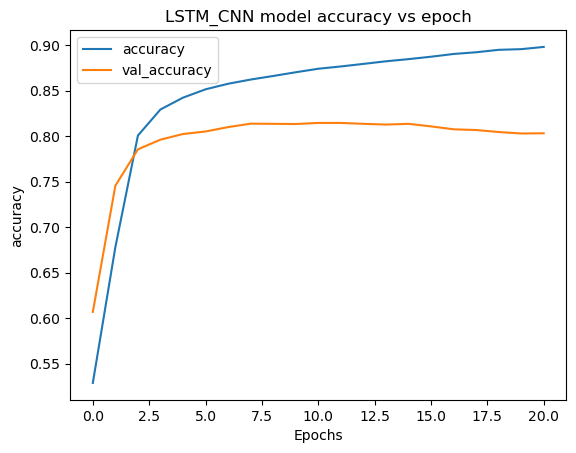

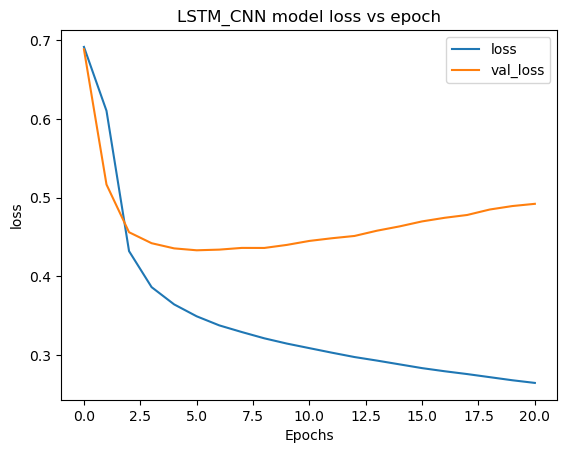

In [35]:
plot_graphs(lstm_cnn_hist, 'accuracy', "LSTM_CNN model accuracy vs epoch")
plot_graphs(lstm_cnn_hist, 'loss', "LSTM_CNN model loss vs epoch")

### Evaluation on test set

We evaluate the four models on the test set using accuracy as our evaluation metric. We also collect the validation accuracy as an additional evaluation metric.

In [36]:
def evaluate_model(model):
    valid_accuracy = model.evaluate(valid_dataset.batch(256))[1]
    test_accuracy = model.evaluate(test_dataset.batch(256))[1]
    print("Validation Accuracy: {}".format(valid_accuracy))
    print("Test Accuracy: {}".format(test_accuracy))

In [37]:
evaluate_model(lstm)

20/20 [==============================] - 0s 10ms/step - loss: 0.3909 - accuracy: 0.8264
Validation Accuracy: 0.8166000247001648
Test Accuracy: 0.8263999819755554


In [38]:
evaluate_model(cnn)

20/20 [==============================] - 0s 5ms/step - loss: 0.4025 - accuracy: 0.8252
Validation Accuracy: 0.8140000104904175
Test Accuracy: 0.8252000212669373


In [39]:
evaluate_model(cnn_lstm)

20/20 [==============================] - 0s 6ms/step - loss: 0.4009 - accuracy: 0.8180
Validation Accuracy: 0.8086000084877014
Test Accuracy: 0.8180000185966492


In [40]:
evaluate_model(lstm_cnn)

20/20 [==============================] - 0s 10ms/step - loss: 0.4182 - accuracy: 0.8218
Validation Accuracy: 0.8145999908447266
Test Accuracy: 0.8217999935150146


### Results and Discussion

| **Model** | **Architecture**  | **Validation Accuracy** | **Test Accuracy** |
|-----------|-------------------|-------------------------|-------------------|
| lstm      | Bi-LSTM           | 0.8166                  | 0.8264            |
| cnn       | 1D Convolution    | 0.8140                  | 0.8252            |
| cnn_lstm  | 1D Conv + Bi-LSTM | 0.8086                  | 0.8180            |
| lstm_cnn  | Bi-LSTM + 1D Conv | 0.8146                  | 0.8218            |    |

The evaluation results are displayed in the table above.

From the table, we can observe that the LSTM model has the best test accuracy of `0.8264`. The CNN_LSTM model performed the worst, but it still achieved a test accuracy of `0.8180`, which is closely behind. I would say that the four models have comparable performance.

One challenge we faced during model training is with the Adam optimizer. Regardless of what the initial learning rate was, the models always train too fast. The model started to overfit, with fluctuating accuracy and increasing loss within 5 epochs. 

I changed the optimizer to AdamW and applied a weight decay, which seems to solve this issue. And I did get slightly better accuracy with this new setup. I also used Early Stopping to prevent overfitting. If we look at the loss vs epoch plots, the slope on the curves seem to suggest that we have a good setup.

## Further Modeling

### LSTM2:

Since LSTM is the best performing model in the section above, I wanted to try tuning it to see if I can get better performance. The first proposed modification on LSTM model is outlined in the plot below.

In the original LSTM model, we just just one FC layer. In LSTM #2, we use an additional FC layer between the Bi-LSTM layer and the last FC layer.

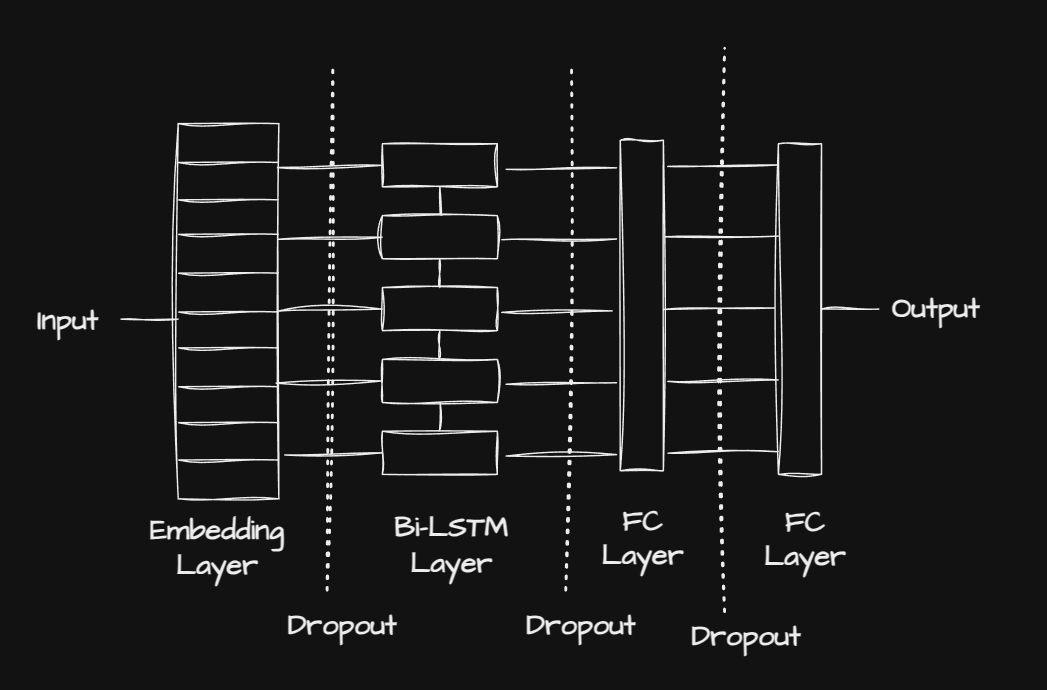

In [41]:
lstm2 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ]
)

lstm2.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

lstm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 48, 128)           640128    
                                                                 
 dropout_5 (Dropout)         (None, 48, 128)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [42]:
lstm2_hist = lstm2.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)

Epoch 1/50
157/157 - 12s - loss: 0.6928 - accuracy: 0.5168 - val_loss: 0.6921 - val_accuracy: 0.5612 - 12s/epoch - 74ms/step
Epoch 2/50
157/157 - 3s - loss: 0.6908 - accuracy: 0.5589 - val_loss: 0.6869 - val_accuracy: 0.6080 - 3s/epoch - 17ms/step
Epoch 3/50
157/157 - 3s - loss: 0.6229 - accuracy: 0.6604 - val_loss: 0.5446 - val_accuracy: 0.7318 - 3s/epoch - 17ms/step
Epoch 4/50
157/157 - 3s - loss: 0.4994 - accuracy: 0.7607 - val_loss: 0.4631 - val_accuracy: 0.7810 - 3s/epoch - 17ms/step
Epoch 5/50
157/157 - 3s - loss: 0.4533 - accuracy: 0.7909 - val_loss: 0.4473 - val_accuracy: 0.7902 - 3s/epoch - 17ms/step
Epoch 6/50
157/157 - 3s - loss: 0.4335 - accuracy: 0.8020 - val_loss: 0.4366 - val_accuracy: 0.7932 - 3s/epoch - 17ms/step
Epoch 7/50
157/157 - 3s - loss: 0.4169 - accuracy: 0.8130 - val_loss: 0.4288 - val_accuracy: 0.7990 - 3s/epoch - 17ms/step
Epoch 8/50
157/157 - 3s - loss: 0.4067 - accuracy: 0.8161 - val_loss: 0.4222 - val_accuracy: 0.7982 - 3s/epoch - 17ms/step
Epoch 9/50
157

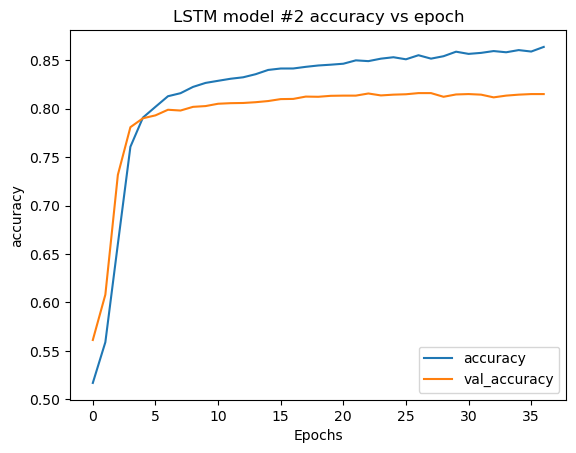

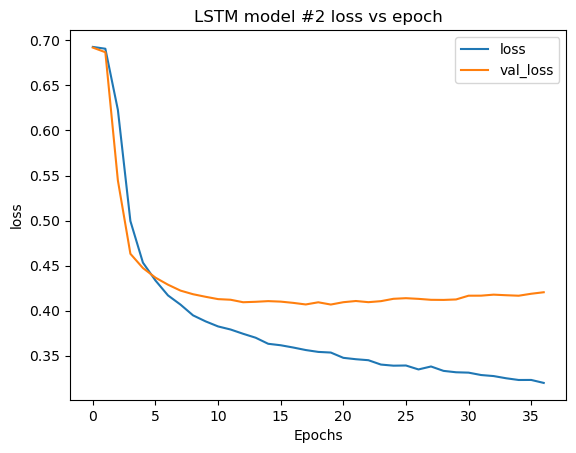

In [43]:
plot_graphs(lstm2_hist, 'accuracy', "LSTM model #2 accuracy vs epoch")
plot_graphs(lstm2_hist, 'loss', "LSTM model #2 loss vs epoch")

In [44]:
evaluate_model(lstm2)

20/20 [==============================] - 0s 9ms/step - loss: 0.3894 - accuracy: 0.8276
Validation Accuracy: 0.8162000179290771
Test Accuracy: 0.8276000022888184


### LSTM3

Another attempt at improving the model performance is to stack LSTM layers. In the proposed LSTM #3 outlined below, we use two Bi-LSTM layers.

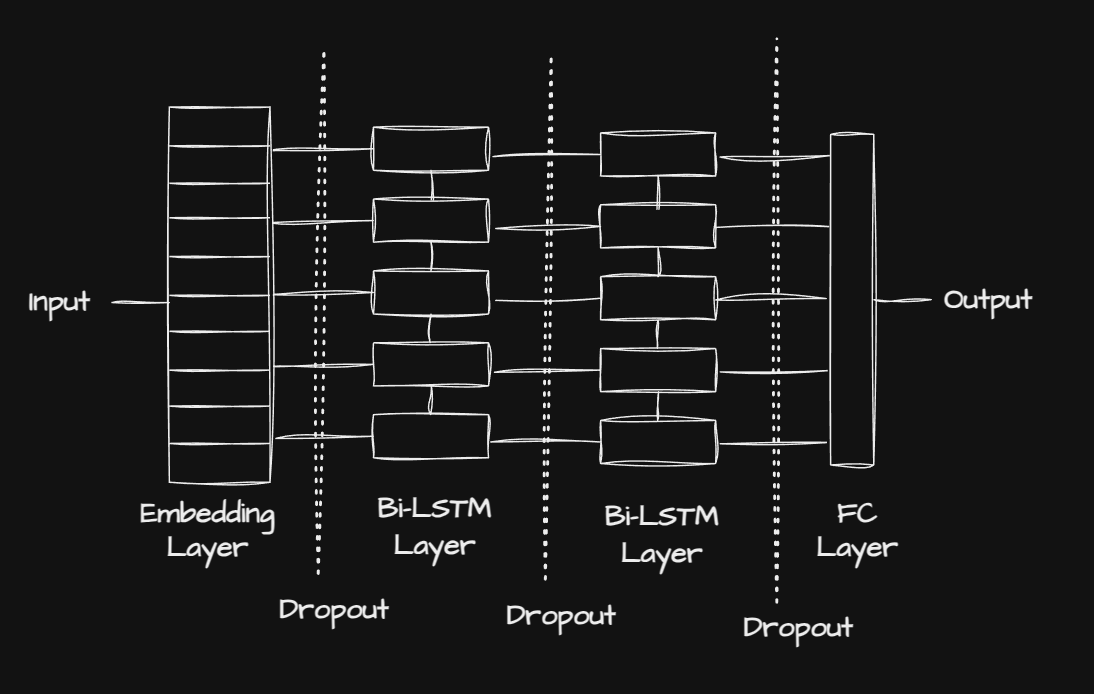

In [45]:
lstm3 = Sequential(
    [
        vectorize_layer,
        Embedding(input_dim=max_features + 1, output_dim=128),
        Dropout(0.5),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

lstm3.compile(
    loss='binary_crossentropy',
    optimizer=AdamW(learning_rate, beta_1=0.5, weight_decay=1e-4),
    metrics=['accuracy']
)

lstm3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 48)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 48, 128)           640128    
                                                                 
 dropout_8 (Dropout)         (None, 48, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 48, 256)           263168    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 48, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)              

In [46]:
lstm3_hist = lstm3.fit(train_dataset.batch(256),
             batch_size=256,
             epochs=50,
             validation_data=valid_dataset.batch(256),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)],
             verbose=2)

Epoch 1/50
157/157 - 15s - loss: 0.6923 - accuracy: 0.5307 - val_loss: 0.6908 - val_accuracy: 0.5778 - 15s/epoch - 93ms/step
Epoch 2/50
157/157 - 9s - loss: 0.6368 - accuracy: 0.6354 - val_loss: 0.5060 - val_accuracy: 0.7450 - 9s/epoch - 54ms/step
Epoch 3/50
157/157 - 8s - loss: 0.4935 - accuracy: 0.7606 - val_loss: 0.4668 - val_accuracy: 0.7726 - 8s/epoch - 54ms/step
Epoch 4/50
157/157 - 9s - loss: 0.4568 - accuracy: 0.7832 - val_loss: 0.4489 - val_accuracy: 0.7818 - 9s/epoch - 54ms/step
Epoch 5/50
157/157 - 9s - loss: 0.4335 - accuracy: 0.7998 - val_loss: 0.4369 - val_accuracy: 0.7886 - 9s/epoch - 54ms/step
Epoch 6/50
157/157 - 9s - loss: 0.4212 - accuracy: 0.8054 - val_loss: 0.4299 - val_accuracy: 0.7924 - 9s/epoch - 54ms/step
Epoch 7/50
157/157 - 9s - loss: 0.4090 - accuracy: 0.8144 - val_loss: 0.4259 - val_accuracy: 0.7948 - 9s/epoch - 54ms/step
Epoch 8/50
157/157 - 9s - loss: 0.3992 - accuracy: 0.8189 - val_loss: 0.4212 - val_accuracy: 0.8008 - 9s/epoch - 55ms/step
Epoch 9/50
157

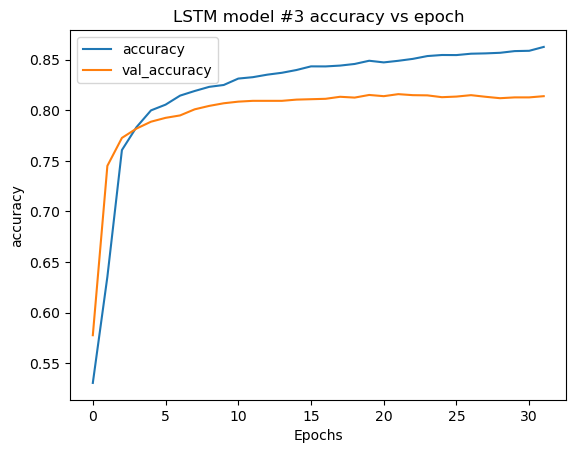

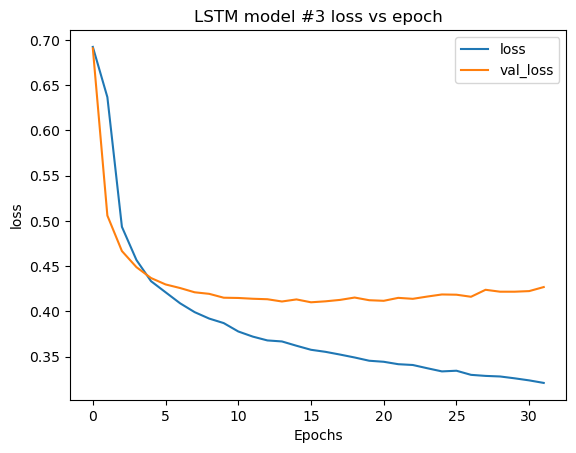

In [47]:
plot_graphs(lstm3_hist, 'accuracy', "LSTM model #3 accuracy vs epoch")
plot_graphs(lstm3_hist, 'loss', "LSTM model #3 loss vs epoch")

In [48]:
evaluate_model(lstm3)

20/20 [==============================] - 0s 18ms/step - loss: 0.3908 - accuracy: 0.8254
Validation Accuracy: 0.8158000111579895
Test Accuracy: 0.8253999948501587


### Results and Discussion

| **Model** | **Architecture**              | **Validation Accuracy** | **Test Accuracy** |
|-----------|-------------------------------|-------------------------|-------------------
| lstm      | Bi-LSTM           | 0.8166                  | 0.8264            ||
| lstm2     | Bi-LSTM + additional FC layer | 0.8162                  | 0.8276            |
| lstm3     | Stacked Bi-LSTM               | 0.8158                  | 0.8254            |

The evaluation results of the two updated models and the original LSTM model are stored in the table above.

Using an additional FC layer improves the test accuracy to `0.8276`, and stacking 2 Bi-LSTM layer reduces the test accuracy to `0.8254`, both of which are what I would consider statistically insignificant. So our attempt to improve the LSTM model did not really work.

## Further Analysis

To better understand why none of the model seems to be getting better prediction accuracy, we check out some of the mis-classified reviews below. Since the data set after cleansing isn't exactly readable, we re-import the test data set.

In [50]:
yp = lstm.predict(test_dataset.batch(256))

20/20 [==============================] - 2s 54ms/step


In [52]:
yp = (yp > 0.5).astype(int)

In [71]:
df_test_original = pd.read_csv("data/Test.csv")
df_test_original['pred'] = yp

In [91]:
with pd.option_context('display.max_colwidth', None):
    display(df_test_original[df_test_original['pred'] != df_test_original['label']].sample(3))

,text,label,pred
945,"'Blade' would be an extremely above-average comic-book, vampire-hunter action/horror if it weren't for two minor flaws. #1 I loved seeing the all-but invincible Blade/Snipes do his slicing and dicing, but the whole ""Yes!"" fist/punch was literally a letdown. #2 Bad, no make that horrible, CGI  even for 1998 standards. This is mainly in the last third, but some sprinkled throughout. Okay, despite those minor infractions, I really enjoyed this movie. All actors did a suburb job and the fact that this now looks like yet another 'Matrix' rip-off is hilarious considering this came out one year prior. So maybe 'The Matrix' copied 'Blade.' At any rate, it's a very movie for multiple genre-loving audiences: Comic Book geeks, action fanatics and horror/vampire lovers. So, we have Blade, half-man/half-vampire, or ""day-walker"" and his accomplish, Whisler (a la ""Batman and Alfred"") battling the undead who, apparently almost out number humans. Who knew? In a rare act of humanity (Blade's more of an antihero) our sword ninja/vamp rescues a newly infected (coincidentally) blood specialist/doctor. Meanwhile, trouble brews amongst the vampires as one wants (you guessed it) supreme power and needs Blade somehow to obtain it. It's not the most original concept, if you read what I just wrote, but still highly enjoyable. You will want to see Blade succeed, you will root for him despite his imperfections and mannerisms. And you will know what's coming as this is the typical act 1-2-3 of a comic book introduction movie. Still, watch this without trying to go too deep. Such as Vampire SPF-1000 ""suntan lotion""? Really? What about the scalp? Wouldn't that still burn? Just like the money they burn for weapons? Uh, okay, I am going too deep. Once again, sit back and enjoy the techno-charged fun ride.",1,0
3778,"After seeing a heavily censored version of this movie on television years ago, I was curious to see the unedited version. I was surprised that it was more believable and well acted than I remembered, but one thing really stood out. I think other reviewers have mentioned this also, namely, what exactly is the nature and motivation of the Chris Sarandon character? Has he raped other victims before? Is he completely psychotic or an ""average"" sociopath? How did he expect to get away with his attack on the younger sister? Is this character at all credible, or is it just a matter of more background being necessary? He seems almost simultaneously to be an uncomfortably believable character, and too crazy to actually be able to hold on to a teaching job that puts him in contact with young, vulnerable girls. This seems to to be the biggest complaint of viewers in general. It has nothing to do with his performance, which is terrifyingly convincing.The movie occupies an uneasy position between sheer exploitation and a half way serious treatment of the subject, without quite settling into either mode. Not the worst movie ever made, but not all that good, either.",0,1
2113,"What was always missing with the Matrix story was how things came to be in the real world. Say no more, because this part of the story covered most of the bases. What was truly interesting was how political it was, maybe even a cheap shot at the current presidential administration. Fascism and violence were the only things man could think of in regards to fighting the robotic horde, who were meant as nothing more than servants to humanity. What I also found interesting was the use of fear and how it was perpetuated by the idea of the unknown. We as humans tend to fall into that trap quite often, letting the lack of logic and thought overtake us because people can't believe the contrary. Well represented and put together, this a true testament to how illogical humans can be.",1,0


For comparison, we also check out some reviews that the LSTM model correctly predicted.

In [79]:
with pd.option_context('display.max_colwidth', None):
    display(df_test_original[df_test_original['pred'] == df_test_original['label']].sample(3))

,text,label,pred
362,"This oddity contains Bunuel-like touches, but doesn't sustain one's interest. A 10 year old roams a bizarro America in a stolen Mustang, while the usual cult movie suspects (Dick Miller, Mary Woronov, Susie Tyrell) commit malicious acts in the name of comedy. Like his AFTER HOURS and VAMPIRE'S KISS, the screenwriter delights in making you squirm. I remained unaffected, due to the broad acting. You know you're in for it when Meat Loaf and Flea give the most appealing perfs. (And what did this kid's screen test look like? He's insufferable.) Recommended to the dozen or so fans of SONNY BOY ('87).",0,0
1117,"This movie is absolutely pointless, one of the good esamples how Malcom McDowall never got one decent role after Clockwork Orange. This one may be one of the worst though. No story, crappy special effects, shot in 4:3/or even worse cropped on DVD, just avoid it ....",0,0
4118,"In the groovy mid 70's a scruffy bunch of brash young Venice, California adolescents from broken homes and the bad side of town known as the Z-Boys turned the previously staid world of professional skateboarding on its ear with their fierce punk attitude, radical unconventional riding style, and unbridled spirit of pure in-your-face aggression, revolutionizing the sport in the process and paving the way for the many extreme variations on sports that popped up in their influential wake. Director Stacy Peralta, who's one of the legendary Z-Boys himself, relates the incredible exploits of this amazing ragtag crew in a ferociously punchy and visceral manner that's both informative and wildly entertaining: the snappy rapid-fire editing, ceaseless speedy pace, and raw, gritty photography deliver one hell of an infectiously kinetic buzz, projecting a sense of sheer joy and full-on bustling energy that's a total pleasure to behold. Better still, this documentary neither sanitizes nor romanticizes its subjects: These rough'n'scrappy lads were so fiercely competitive and out for themselves that they all went their separate ways when the lure of fame and fortune manifested in their lives. The ultimate fates of certain guys is poignant and heartbreaking, with gifted and spontaneous ace skateboard rat Jay Adams rating as the saddest and most tragic: He blew his chance at the big time and wound up doing time in jail. The other dudes are very colorful and personable as well; charismatic ball of cocky and defiant fire Tony Alva in particular comes across as one arrogant, yet impressive piece of furiously assertive work. Marvelously narrated with delightfully easy'n'breezy nasal nonchalance by Sean Penn. The terrific rock soundtrack likewise seriously smokes. But what really makes this documentary such a winner is its refreshing complete dearth of pretense: It's every bit as dynamic, exuberant and larger-than-life extraordinary as the gloriously outrageous Z-Boys themselves.",1,1


As a non-native English speaker, I did not really understand the emotion behind some of the mis-classified reviews. And I don't necessarily agree with all the labels on them. On the other hand, the correctly predicted reviews feel straightforward and I can easily tell the sentiment.

So here is the thing. Figure of speech and rhetorical device is sometimes difficult to understand. There is apparently a portion of reviews that are not written in the most straightforward or direct way. So this probably helps explain why all the models get test accuracy of around 0.81 to 0.82. 

Another contributing factor is that the data set used in this project is made in 2011. NLP has developed so much in the last 10 years, and even the most basic model we used in this project is quite advanced by 2011 standards. Had we been using more challenging data set, we may start to notice a difference in the model performance.

## Conclusion

In this project, we built four deep learning models to predict the sentiment of movie reviews, with the best model approaching an accuracy of 83% on the test set. We subsequently made modification on the best performing model, but we were unable to achieve better results.

For future projects, we should consider using a more challenging data set to be able to differentiate the model performance. In this project, all the models perform very similarly. And I believe it's because most of the reviews in the data set are easy to classify.

A common approach to sentiment analysis is to apply a pre-trained lanauge model like BERT. I decided against it for this project because I wanted to demonstrate what I have learned in this course. But in the future, using a pre-trained model is definitely something I should consider. 
  

## References
- Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). _Learning Word Vectors for Sentiment Analysis_. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142–150). Association for Computational Linguistics.
- Sosa, P. (2017). _Twitter Sentiment Analysis using combined LSTM-CNN Models_. Unpublished manuscript. Downloaded from academic.edu, University of California, Santa Barbara. https://www.academia.edu/35947062/Twitter_Sentiment_Analysis_using_combined_LSTM_CNN_Models